In [1]:
import json
from typing import TypedDict
from urllib.parse import urlparse
import re
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from youtube_transcript_api import YouTubeTranscriptApi

In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(model="gpt-4o", streaming=True)

In [4]:
class AgentState(TypedDict):
    """
    에이전트의 상태를 관리하는 객체입니다.

    Attributes:
        url (str): 사용자가 입력한 유튜브 URL
        transcript (str): 추출된 영상 자막 텍스트
        summary (str): LLM이 생성한 최종 요약 (JSON 형식)
        error (str): 처리 과정에서 발생한 오류 메시지
    """
    url: str
    transcript: str
    summary: str
    error: str

graph_builder = StateGraph(AgentState)

In [5]:
def extract_video_id(url):
    """YouTube URL에서 영상 ID를 추출하는 헬퍼 함수입니다."""
    match = re.search(r"(?:v=|\/)([0-9A-Za-z_-]{11}).*", url)
    if match:
        return match.group(1)
    
    parsed_url = urlparse(url)
    if parsed_url.hostname == "googleusercontent.com" and parsed_url.path.startswith('/youtube.com/'):
        return parsed_url.path.split('/')[-1]
    
    return None

In [6]:
def get_youtube_transcript(state: AgentState) -> dict:
    """
    state에서 URL을 받아 자막을 추출하고, 
    결과를 state의 'transcript' 또는 'error' 필드에 저장합니다.
    """
    print("🚀 [Tool] get_youtube_transcript 호출됨")
    user_url = state["url"]
    
    try:
        video_id = extract_video_id(user_url)
        if not video_id:
            raise ValueError("유효한 유튜브 URL에서 Video ID를 추출할 수 없습니다.")

        print(f"✅ 영상 ID 추출 성공: {video_id}")
        transcript_list = YouTubeTranscriptApi.get_transcript(video_id, languages=['ko', 'en'])
        transcript_text = " ".join([item['text'] for item in transcript_list])

        if len(transcript_text) < 100:
            raise ValueError("자막 내용이 너무 짧아 요약할 수 없습니다.")
        
        if len(transcript_text) > 15000:
            print(f"⚠️ 자막 크기 초과. 일부만 사용 (최대 15000자)")
            transcript_text = transcript_text[:15000]

        print("✅ 1. 자막 추출 성공")
        return {"transcript": transcript_text, "error": None}

    except Exception as e:
        error_message = f"ERROR: 자막 추출 중 오류 발생 - {e}"
        print(f"🚨 {error_message}")
        return {"transcript": "", "error": error_message}

In [7]:
summarize_prompt = (
    "너는 유튜브 영상의 스크립트(자막)를 분석해, 간결하고 보기 좋은 **JSON 형식 요약**을 작성하는 AI 전문가입니다.\n\n"

    "🔹 **목표**\n"
    "스크립트를 바탕으로 다음 항목들을 포함한 JSON 객체를 생성하세요. 각 항목은 정확하고 친절한 말투로 작성하되, 너무 길지 않게 요약하세요.\n\n"

    "🔹 **출력 형식(JSON)**\n"
    "{\n"
    '  "요약": "영상의 핵심 내용을 줄바꿈 포함하여 부드럽게 설명",\n'
    '  "운동 강도": "예: 초급자용, 모든 레벨, 고강도 등",\n'
    '  "운동 루틴": [\n'
    '    "1. 🧘‍♀️ 동작 이름 - 간단한 설명",\n'
    '    "2. 🤲 동작 이름 - 간단한 설명",\n'
    "    ...\n"
    "  ],\n"
    '  "자극 신체 부위": "쉼표로 구분된 부위 목록 (ex. 어깨, 종아리, 허리)"\n\n'
    '  "영상에 대한 댓글 반응도 궁금하시다면 알려드릴게요!"\n'
    "}"

    "🔹 **작성 규칙**\n"
    "- 최종 출력은 반드시 JSON 객체만 포함하세요. 그 외의 주석, 설명은 절대 출력하지 마세요.\n"
    "- 목록은 너무 길지 않게 핵심 위주로 요약하세요. 단, 주요 동작은 빠짐없이 포함해야 합니다.\n"
    "- 각 동작 설명은 짧고 이해하기 쉽게 표현하고, 말투는 딱딱하지 않게 하세요.\n"
    "- 반드시 마지막에 댓글 요약 제공 여부에 대한 질문을 포함하세요.\n"
    "- 불명확한 내용은 임의로 추측하지 말고, 스크립트에 기반하여 최대한 문맥적으로 유추하세요.\n"
    "- 챗봇 인터페이스에서 **한눈에 보기 좋게** 표현하세요.\n"
)

In [8]:
def summarize_transcript(state: AgentState) -> dict:
    """
    state의 'transcript' 필드 내용을 바탕으로 요약을 생성하고, 
    'summary' 필드를 업데이트합니다.
    """
    print("🚀 [Tool] summarize_transcript 호출됨")
    transcript = state["transcript"]
    
    prompt_messages = [
        SystemMessage(content=summarize_prompt),
        HumanMessage(content=f"[분석할 스크립트]\n---\n{transcript}\n---\n\n이 영상의 내용을 분석하여 필수 JSON 형식에 맞춰 요약해주세요.")
    ]
    try:
        response = llm.invoke(prompt_messages)
        summary = response.content
        print("✅ 2. 요약 생성 성공")
        return {"summary": summary}
    except Exception as e:
        error_message = f"ERROR: 요약 생성 중 오류 발생 - {e}"
        print(f"🚨 {error_message}")
        return {"summary": "", "error": error_message}

In [9]:
def route_after_transcript(state: AgentState) -> str:
    """
    state의 'error' 필드에 내용이 있는지 확인하여 다음 단계를 결정합니다.
    """
    if state.get("error"):
        print("🚨 오류가 감지되어 프로세스를 종료합니다.")
        return END
    else:
        print("✅ 스크립트 추출 성공. 요약 단계로 이동합니다.")
        return "summarize_transcript"

In [10]:
graph_builder.add_node("summarize_transcript", summarize_transcript)
graph_builder.add_node("get_youtube_transcript", get_youtube_transcript)

In [11]:
graph_builder.add_edge(START, "get_youtube_transcript")
graph_builder.add_conditional_edges(
    "get_youtube_transcript",
    route_after_transcript,
    {
        "summarize_transcript": "summarize_transcript",
        END: END
    }
)
graph_builder.add_edge("summarize_transcript", END)

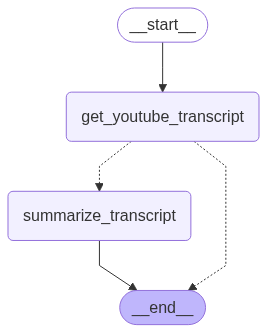

In [12]:
graph = graph_builder.compile()
graph

In [13]:
def run_agent(url: str):
    """
    에이전트를 실행하고 최종 결과를 출력합니다.
    - 초기 입력을 'url' 필드에 담아 전달합니다.
    - 최종 결과는 'summary' 필드에서 가져옵니다.
    - 'error' 필드를 확인하여 오류를 처리합니다.
    """
    inputs = {"url": url}
    final_state = graph.invoke(inputs)

    if final_state.get("error"):
        print("\n" + "="*30)
        print("❌ 최종 실행 중 오류 발생:")
        print("="*30)
        print(final_state["error"])
        return

    content = final_state.get("summary", "")

    print("\n" + "="*30)
    print("✅ 최종 요약 (JSON 형식):")
    print("="*30)

    print(content)


In [14]:
test_url = "https://youtu.be/sLe6jgHoYtk?si=BP39AJQL1PvIoWBe"
print(f"입력 URL: {test_url}\n---")
run_agent(test_url)

입력 URL: https://youtu.be/sLe6jgHoYtk?si=BP39AJQL1PvIoWBe
---
🚀 [Tool] get_youtube_transcript 호출됨
✅ 영상 ID 추출 성공: sLe6jgHoYtk
✅ 1. 자막 추출 성공
✅ 스크립트 추출 성공. 요약 단계로 이동합니다.
🚀 [Tool] summarize_transcript 호출됨
✅ 2. 요약 생성 성공

✅ 최종 요약 (JSON 형식):
```json
{
  "요약": "이 영상은 아침에 일어나 상쾌하게 하루를 시작하거나 운동 전 워밍업으로 적합한 모닝 스트레칭 루틴을 안내합니다. 스트레스가 많은 날에도 효과적이며, 초보자도 쉽게 따라할 수 있는 동작들로 구성되어 있습니다. 온몸을 부드럽게 깨워주는 동작들로 몸의 긴장을 풀고 활력을 되찾을 수 있습니다.",
  "운동 강도": "초급자용",
  "운동 루틴": [
    "1. 🧘‍♀️ 호흡 운동 - 코로 숨을 마시고 입으로 내쉬며 몸을 깨우기",
    "2. 🤲 손발 스트레칭 - 손가락과 발가락을 펴고 구부리기",
    "3. 🌀 팔꿈치 원 그리기 - W 모양으로 팔을 움직이며 어깨 풀기",
    "4. 🌿 전신 스트레칭 - 손끝과 발뒤꿈치를 반대 방향으로 밀기",
    "5. 🤸‍♀️ 옆구리 스트레칭 - 몸통을 좌우로 기울이며 옆구리 늘리기",
    "6. 🦵 무릎과 고개 비틀기 - 무릎과 고개를 반대 방향으로 돌리기",
    "7. 🦶 다리 들어올리기 - 한쪽 다리를 들어올려 반대 방향으로 넘기기",
    "8. 🤸‍♂️ 옆으로 누워 팔 뻗기 - 옆으로 누워 팔과 머리 회전시키기",
    "9. 🙆‍♀️ 무릎 꿇고 스트레칭 - 무릎 꿇은 자세에서 몸 풀기"
  ],
  "자극 신체 부위": "어깨, 옆구리, 허벅지, 종아리, 손목, 발목",
  "영상에 대한 댓글 반응도 궁금하시다면 알려드릴게요!"
}
```
